In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Leitura e visualização dos dados

In [2]:
dados = pd.read_csv("https://raw.githubusercontent.com/kimleone/Poluicao-Atmosferica/main/PoluicaoPucSaoGabriel(Limpo).csv", sep = ';', decimal = ',')
dados = dados.drop(columns = ['Unnamed: 0'])
dados.head()

,DataHora,PM10,NO2,O3,SO2,PM2.5,CO,T,DV,PP,VV,UR
0,01/01/2019 00:30,30.178655,1.81,11.53,5.94,20.074768,0.44,21.13,140.57,0.0,0.89,90.38
1,01/01/2019 01:30,31.221828,1.88,8.69,6.03,20.355807,0.41,21.24,109.40,0.0,0.60,90.02
2,01/01/2019 02:30,30.000000,1.96,4.33,6.19,20.000000,0.42,21.10,90.49,0.0,0.71,91.42
3,01/01/2019 03:30,48.000000,1.69,4.68,6.30,24.000000,0.32,20.90,94.67,0.4,0.75,93.23
4,01/01/2019 04:30,38.217114,0.84,23.70,6.39,21.039405,0.16,20.13,43.44,13.2,1.04,98.71


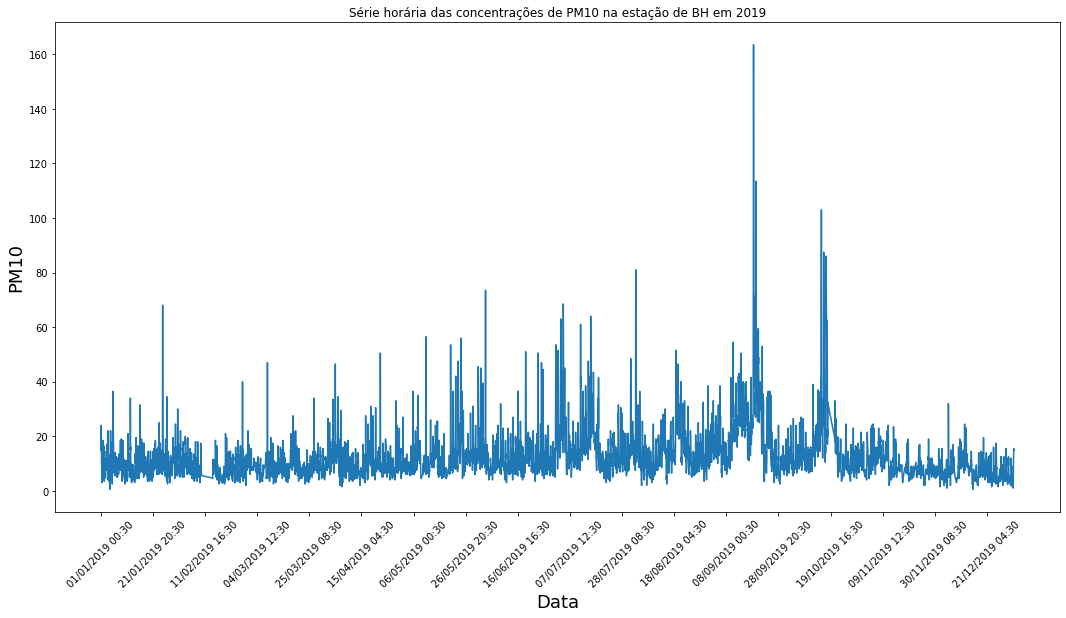

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(dados.shape[0]),(dados['PM10'])/2.0)
plt.xticks(range(0,dados.shape[0],500),dados['DataHora'].loc[::500],rotation=45)
plt.xlabel('Data',fontsize=18)
plt.ylabel('PM10',fontsize=18)
plt.title('Série horária das concentrações de PM10 na estação de BH em 2019')
plt.show()

In [4]:
dados.DataHora = pd.to_datetime(dados.DataHora)
dados = dados.set_index('DataHora')
df = dados['PM10']
df.head(3)

DataHora
2019-01-01 00:30:00    30.178655
2019-01-01 01:30:00    31.221828
2019-01-01 02:30:00    30.000000
Name: PM10, dtype: float64

LSTM

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
#from matplotlib import pyplot
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


Devemos transformar o conjunto de dados para torná-lo adequado para o modelo LSTM. Para isso definimos a função `timeseries_to_supervised`.

In [6]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

Devemos também transformar os dados para que tenham uma escala entre -1 e 1. Para isso iremos usar a função `scale` definida abaixo. Para retornar aos valores reais usamos a função `invert_scale`.

In [7]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

Finalmente definimos as funções `fit_lstm` que treina e retorna um modelo LSTM. 
Uma vez que o modelo LSTM esteja ajustado aos dados de treinamento, ele pode ser usado para fazer previsões. Para isso, definimos a função `forecast_lstm`. Iremos fazer previsões para as ultimas 24 horas do ano de 2019.

In [8]:
# ajustar uma rede LSTM aos dados de treinamento
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model


def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [9]:
raw_values = df.values

# Transforma dados para aprendizado supervisionado
supervised = timeseries_to_supervised(raw_values, 1)
supervised_values = supervised.values

# divide os dados em train e test-sets
train, test = supervised_values[0:-24], supervised_values[-24:]

# transforma a escala dos dados
scaler, train_scaled, test_scaled = scale(train, test)

Vamos ajustar um modelo com 25 neurônios

In [10]:
# Treinando o modelo
lstm_model = fit_lstm(train_scaled, 1, 25, 100)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 100)                  40800     
                                                                 
 dense (Dense)               (1, 1)                    101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
# prever todo o conjunto de dados de treinamento para construir o estado para previsão
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# validação walk-forward nos dados de teste
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i]
	print('hora=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

hora=1, Predicted=14.949043, Expected=16.890790
hora=2, Predicted=15.757115, Expected=18.000000
hora=3, Predicted=16.427003, Expected=10.000000
hora=4, Predicted=9.550953, Expected=10.000000
hora=5, Predicted=9.649906, Expected=9.000000
hora=6, Predicted=9.852446, Expected=8.000000
hora=7, Predicted=8.851977, Expected=7.000000
hora=8, Predicted=8.147784, Expected=4.000000
hora=9, Predicted=5.806995, Expected=3.000000
hora=10, Predicted=5.168168, Expected=5.000000
hora=11, Predicted=7.266447, Expected=6.000000
hora=12, Predicted=8.063647, Expected=7.000000
hora=13, Predicted=8.593679, Expected=8.000000
hora=14, Predicted=9.371322, Expected=6.048261
hora=15, Predicted=7.583864, Expected=4.538017
hora=16, Predicted=6.254717, Expected=2.000000
hora=17, Predicted=4.449693, Expected=6.000000
hora=18, Predicted=8.088043, Expected=13.000000
hora=19, Predicted=14.106024, Expected=15.000000
hora=20, Predicted=15.012981, Expected=16.000000
hora=21, Predicted=15.069030, Expected=26.000000
hora=22,

Por fim, calculamos o desempenho do modelo e plotamos um gráfico comparando valores observados vs preditos.

In [12]:
rmse = sqrt(mean_squared_error(raw_values[-24:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.822


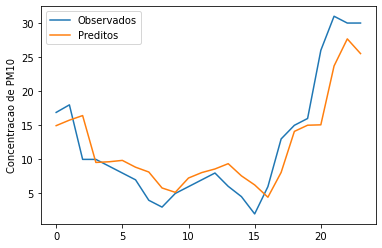

In [15]:
plt.plot(raw_values[-24:], label='Observados') # Observados em azul
plt.plot(predictions,  label='Preditos')
plt.legend()
plt.ylabel('Concentracao de PM10')
plt.show()

Referencias e materiais:


https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/



https://medium.com/neuronio-br/prevendo-valores-de-a%C3%A7%C3%B5es-com-lstm-b7b3a737aa4